## データの読み込み

In [138]:
import pandas as pd
DATA_DIR = 'tracon01/'

train_init = pd.read_csv(DATA_DIR + 'train.csv')
print("train_columns:", train_init.columns)

test_init = pd.read_csv(DATA_DIR + 'test.csv')
print("test_columns:", test_init.columns)

repo = pd.read_csv(DATA_DIR + 'repo.csv')
print("repo_columns:", repo.columns)

commits = pd.read_csv(DATA_DIR + "commits_sampled_10.csv")
print("commits_columns:", commits.columns)

commit_repoids = pd.read_csv(DATA_DIR + "commits_sampled_10_repoids.csv")
print("commits_repoids_columns:", commit_repoids.columns)

issues = pd.read_csv(DATA_DIR + "issues.csv")
print("issues_columns:", issues.columns)

pulls = pd.read_csv(DATA_DIR + "pulls.csv")
print("pulls_columns:", pulls.columns)

train_init['active'].value_counts()

train_columns: Index(['repo_id', 'owner', 'repo', 'active'], dtype='object')
test_columns: Index(['repo_id', 'owner', 'repo'], dtype='object')
repo_columns: Index(['repo_id', 'stars', 'files'], dtype='object')
commits_columns: Index(['commit', 'repo_names', 'parent', 'author_name', 'author_date',
       'committer_date', 'author_timezonedelta', 'committer_timezonedelta',
       'message'],
      dtype='object')
commits_repoids_columns: Index(['commit', 'repo_ids'], dtype='object')
issues_columns: Index(['issue_id', 'repo_id', 'state', 'created_at', 'closed_at', 'opened_by',
       'title', 'body'],
      dtype='object')
pulls_columns: Index(['pull_id', 'repo_id', 'state', 'created_at', 'closed_at', 'opened_by',
       'title', 'body'],
      dtype='object')


active
False    2698
True      985
Name: count, dtype: int64

## データの処理と選定

In [139]:
from datetime import datetime as dt

### コミット情報のデータフレーム作成

In [140]:
repo_commit_count = {}
repo_latest_commit_date = {}
repo_latest_commit_date_log = {} # 2022/01/02 00:00 - 最終コミット日時 の対数。date をそのまま使った方がいい結果が出た
repo_commit_members = {}
repo_commit_mes_length = {} # コミットメッセージ合計長
repo_commit_mes_avelength = {}

commits = commits.merge(commit_repoids, on="commit", how="left")

for row in commits.itertuples():
    try:
        date = dt.strptime(row.author_date, "%Y-%m-%d %H:%M:%S").timestamp()
    except TypeError:
        print(row.author_date)
        date = dt.strptime("2020-01-01 00:00:00", "%Y-%m-%d %H:%M:%S").timestamp()
    
    for repo_id in eval(row.repo_ids): # コミットに対象のリポジトリが複数あるってどういうことだ？
        repo_commit_count[repo_id] = repo_commit_count.get(repo_id, 0) + 1 # 1追加
        repo_latest_commit_date[repo_id] = max(repo_latest_commit_date.get(repo_id, 0), date)
        if repo_id not in repo_commit_members:
            repo_commit_members[repo_id] = {}
        repo_commit_members[repo_id][row.author_name] = repo_commit_members[repo_id].get(row.author_name, 0) + 1
        # type(row.message) が float なことがあるのはなぜ？
        repo_commit_mes_length[repo_id] = repo_commit_mes_length.get(repo_id, 0) + len(str(row.message))

# コミットメッセージの平均長さを計算
for repo_id in repo_commit_mes_length.keys():
    repo_commit_mes_avelength[repo_id] = repo_commit_mes_length[repo_id] / repo_commit_count[repo_id]

# データフレームへの変換
repo_commit_count_df = pd.DataFrame(
    {"repo_id": repo_commit_count.keys(), "n_commits": repo_commit_count.values()}
)
repo_latest_commit_date_df = pd.DataFrame(
    {"repo_id": repo_latest_commit_date.keys(), "latest_commit_date": repo_latest_commit_date.values()}
)
repo_commit_members_df = pd.DataFrame(
    {"repo_id": repo_commit_members.keys(), "n_commit_members": [len(e) for e in repo_commit_members.values()]}
)
repo_commit_mes_length_df = pd.DataFrame(
    {"repo_id": repo_commit_members.keys(), "commit_mes_length": repo_commit_mes_length.values()}
)
repo_commit_mes_avelength_df = pd.DataFrame(
    {"repo_id": repo_commit_members.keys(), "commit_mes_avelength": repo_commit_mes_avelength.values()}
)

### イシュー情報のデータフレーム作成

In [141]:
issue_count = {}
issue_openers = {}
latest_issue_date = {}

# commits_sampled_10 に対応する issue の中では、なぜか losed の issue が 6 件しかないという偏りが生じていそう

for row in issues.itertuples():
    issue_count[row.repo_id] = issue_count.get(row.repo_id, 0) + 1
    date = dt.strptime(row.created_at[:10] + " " + row.created_at[11:19], "%Y-%m-%d %H:%M:%S").timestamp()
    latest_issue_date[row.repo_id] = max(latest_issue_date.get(row.repo_id, 0), date)
    if row.repo_id not in issue_openers:
        issue_openers[row.repo_id] = {}
    issue_openers[row.repo_id][row.opened_by] = issue_openers[row.repo_id].get(row.opened_by, 0) + 1
    # if row.state != "open":
    #     print(row.state)

issue_count_df = pd.DataFrame(
    {"repo_id": issue_count.keys(), "n_issues": issue_count.values()}
)
issue_openers_df = pd.DataFrame(
    {"repo_id": issue_openers.keys(), "n_issue_openers": [len(e) for e in issue_openers.values()]}
)
latest_issue_date_df = pd.DataFrame(
    {"repo_id": latest_issue_date.keys(), "latest_issue_date": latest_issue_date.values()}
)

### プルリクエスト情報のデータフレーム作成

In [142]:
pull_count = {}
latest_pull_date = {}

# commits_sampled_10 に対応するプルリクエストに至っては closed が 1 件もない

for row in pulls.itertuples():
    pull_count[row.repo_id] = pull_count.get(row.repo_id, 0) + 1
    # date = dt.strptime(row.created_at[:-6], "%Y-%m-%d %H:%M:%S").timestamp()
    date = dt.strptime(row.created_at[:10] + " " + row.created_at[11:19], "%Y-%m-%d %H:%M:%S").timestamp()
    latest_pull_date[row.repo_id] = max(latest_pull_date.get(row.repo_id, 0), date)
    # if row.state != "open":
    #     print(row.state)

pull_count_df = pd.DataFrame(
    {"repo_id": pull_count.keys(), "n_pulls": pull_count.values()}
)
latest_pull_date_df = pd.DataFrame(
    {"repo_id": latest_pull_date.keys(), "latest_pull_date": latest_pull_date.values()}
)

### マージと選定

In [143]:
train = train_init.copy(deep=True)
test = test_init.copy(deep=True)

train = train.merge(repo, on='repo_id', how='left')
test = test.merge(repo, on='repo_id', how='left')

train["n_stars"] = train["stars"].apply(lambda s: s.count(','))
test["n_stars"] = test["stars"].apply(lambda s: s.count(','))

train["n_files"] = train["files"].apply(lambda s: s.count(','))
test["n_files"] = test["files"].apply(lambda s: s.count(','))

# コミット関係

train = train.merge(repo_commit_count_df, on="repo_id", how="left")
test = test.merge(repo_commit_count_df, on="repo_id", how="left")

train = train.merge(repo_latest_commit_date_df, on="repo_id", how="left")
test = test.merge(repo_latest_commit_date_df, on="repo_id", how="left")

train = train.merge(repo_commit_members_df, on="repo_id", how="left")
test = test.merge(repo_commit_members_df, on="repo_id", how="left")

train = train.merge(repo_commit_mes_length_df, on="repo_id", how="left")
test = test.merge(repo_commit_mes_length_df, on="repo_id", how="left")

train = train.merge(repo_commit_mes_avelength_df, on="repo_id", how="left")
test = test.merge(repo_commit_mes_avelength_df, on="repo_id", how="left")

# プルリクエスト関係

train = train.merge(pull_count_df, on="repo_id", how="left")
test = test.merge(pull_count_df, on="repo_id", how="left")

train = train.merge(latest_pull_date_df, on="repo_id", how="left")
test = test.merge(latest_pull_date_df, on="repo_id", how="left")

# イシュー関係

train = train.merge(issue_count_df, on="repo_id", how="left")
test = test.merge(issue_count_df, on="repo_id", how="left")

train = train.merge(issue_openers_df, on="repo_id", how="left")
test = test.merge(issue_openers_df, on="repo_id", how="left")

train = train.merge(latest_issue_date_df, on="repo_id", how="left")
test = test.merge(latest_issue_date_df, on="repo_id", how="left")

use_cols = ["latest_commit_date", "latest_issue_date", "latest_pull_date"]
use_cols = use_cols + ["n_stars", "n_commits", "n_pulls", "n_issues"]
target_col = "active"

## 学習

In [144]:
import numpy as np
from sklearn.model_selection import KFold # 交差検証用ライブラリ
import lightgbm as lgb # 勾配ブースティング木で学習してくれるやつ

def train_fold(train_X: pd.DataFrame, train_y: pd.Series, valid_X: pd.DataFrame, valid_y: pd.Series) -> lgb.Booster:
    # GBDT の学習のためにデータを変換したうえで、学習を実行する関数
    lgb_train = lgb.Dataset(train_X, train_y)
    lgb_valid = lgb.Dataset(valid_X, valid_y, reference=lgb_train)
    params = {
        'objective': 'binary',
        'metric': ['auc', 'accuracy'],
    }
    model = lgb.train(params, lgb_train, valid_sets=[lgb_valid], callbacks=[lgb.early_stopping(100, first_metric_only=True)])
    return model

models = []
kf = KFold(n_splits=4, shuffle=True, random_state=20) # 4分割交差検証

for train_index, valid_index in kf.split(train): # kf.split(train) は長さ 4 の配列
    # 各 train_index と valid_index は、それぞれ全データの中から訓練用・テスト用に分けられた index の配列
    train_data = train.iloc[train_index]
    valid_data = train.iloc[valid_index]

    train_X = train_data[use_cols]
    train_y = train_data[target_col] # それぞれ学習に使うフィールド、予測したいフィールド
    valid_X = valid_data[use_cols]
    valid_y = valid_data[target_col]

    model = train_fold(train_X, train_y, valid_X, valid_y)
    models.append(model) # 長さ 4 の配列 models ができる

[LightGBM] [Info] Number of positive: 735, number of negative: 2027
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.008912 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1783
[LightGBM] [Info] Number of data points in the train set: 2762, number of used features: 7
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.266112 -> initscore=-1.014442
[LightGBM] [Info] Start training from score -1.014442
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[11]	valid_0's auc: 0.934694
Evaluated only: auc
[LightGBM] [Info] Number of positive: 730, number of negative: 2032
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.007566 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1785
[LightGBM] [Info] Number of data points in the train set: 2762, number of used features:

## Valid の予測

In [145]:
oof_pred = np.zeros(len(train)) # 単に train と同じ長さの 0 で初期化された配列を作る
for i, (train_index, valid_index) in enumerate(kf.split(train)):
    valid_data = train.iloc[valid_index]
    valid_X = valid_data[use_cols] # バリデーションに使うデータの中で、予測の材料となるフィールドの行
    oof_pred[valid_index] = models[i].predict(valid_X)
    # この瞬間に oof_pred は valid_index だけに予測結果が入る

# 4回異なる valid_index で実行することで、ちょうどぴったり oof_pred の全ての要素が埋まる

## 用語の補足

- TPR は「正しく(True) ポジティブと判定された（Positive）割合 (Rate)」
- FPR は「誤って(False)ポジティブと判定された（Positive）割合 (Rate)」
- TNR は 1 - FPR、FNR は 1 - TPR で求められる。これで表が埋まる

今回の Positive は「リポジトリがアクティブである」という命題かな\
モデルは Positive か Negative かを予測するが、本来の予測結果は確率なので 0 ~ 1 の実数値をとる\
0.5 以上で「モデルは Positive と判定した」ことにできるし、0.3 以上とすることもできる\
この閾値をいろいろ変えたとき、TPR と FPR がどう変動するかを変えたときのグラフが ROC 曲線

また、ROC 曲線の下側の面積が AUC。つまり、ある閾値における一致率 Accuracy よりも一般的にモデルの評価ができる\
ROC 曲線が一番張り出して（0, 0）→ (0, 1) → (1, 1) という折れ線であるときこのモデルは完璧、ということになる

## 予測精度の可視化

0.9247649132841398


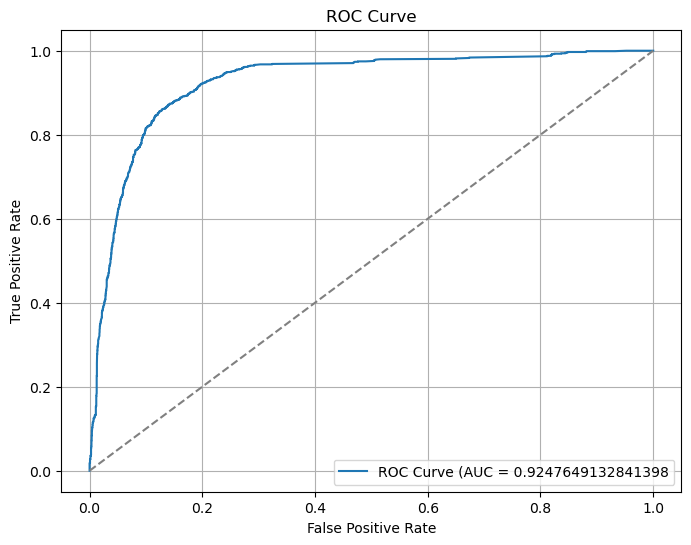

In [146]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_auc_score, roc_curve

score = roc_auc_score(train["active"], oof_pred)
print(score)

# ROC 曲線のプロット
fpr, tpr, thresholds = roc_curve(train["active"], oof_pred)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f'ROC Curve (AUC = {score}')
plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend()
plt.grid()
plt.show()

## 特徴量の重要性評価

/opt/anaconda3/lib/python3.11/site-packages/seaborn/categorical.py:1794: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/anaconda3/lib/python3.11/site-packages/seaborn/categorical.py:1794: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/anaconda3/lib/python3.11/site-packages/seaborn/categorical.py:1794: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/anaconda3/lib/python3.11/site-packages/seaborn/categorical.py:1794: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN 

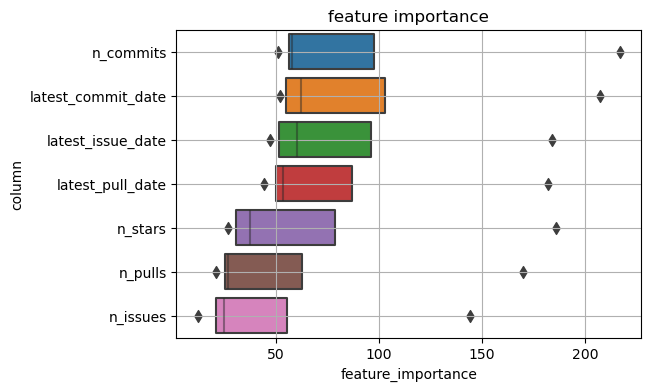

In [147]:
import matplotlib.pyplot as plt
import seaborn as sns

# よくわからん…。けどまぁグラフの意味だけわかればいいか

def plot_importance(models: list):
    feature_importance = pd.DataFrame()
    
    for i, model in enumerate(models):
        _df = pd.DataFrame()
        _df['feature_importance'] = model.feature_importance()
        _df['column'] = model.feature_name()
        _df['fold'] = i + 1
        feature_importance = pd.concat([feature_importance, _df], axis=0, ignore_index=True)

    order = feature_importance.groupby('column').sum()[['feature_importance']].sort_values('feature_importance', ascending=False).index

    plt.figure(figsize=(6, 4))
    sns.boxenplot(data=feature_importance, x='feature_importance', y='column', order=order)
    plt.title('feature importance')
    plt.grid()
    plt.show()

plot_importance(models)

# random_state を変えると結構貢献度も変わる

## 実際のテストデータの予測

In [148]:
import datetime

sample_sub = pd.read_csv(DATA_DIR + 'sample_submission.csv')
pred = np.zeros(sample_sub.shape[0]) # sample_sub.shape[0] はつまり縦の長さ（= 1814）

for model in models:
    pred += model.predict(test[use_cols])

pred /= len(models) # すべての要素を一気に 4 で割って平均値を得て、
sample_sub["pred"] = pred # それをサンプル提出データの "pred" 行に突っ込む
sample_sub.to_csv(f"output/{datetime.datetime.now()}.csv", index=False)